# Denoising Diffusion Implicit Modeling

> In this module, we improve the sampling algorithm to further improve the realism and speed of our Generative Fashion MNIST model

Adapted from

- [https://youtu.be/PXiD7ZjOKhA?si=TfIshEqYmGL7cGwV&t=5541](https://youtu.be/PXiD7ZjOKhA?si=TfIshEqYmGL7cGwV&t=5541)

In [1]:
#| default_exp ddim

In [2]:
# |export
from dataclasses import dataclass
from functools import partial
from pathlib import Path

import matplotlib.animation
import matplotlib.pyplot as plt
import torch
from diffusers import (
    DDIMPipeline,
    DDIMScheduler,
    DDPMPipeline,
    DDPMScheduler,
    UNet2DModel,
)
from IPython.display import HTML
from IPython.utils import io
from tqdm import tqdm

from slowai.augmentation import GlobalAveragePooling, ResNetWithGlobalPoolingInitialConv
from slowai.ddpm import DDPM, get_dls, train
from slowai.fid import ImageEval
from slowai.learner import def_device
from slowai.utils import show_images

In [3]:
import matplotlib

matplotlib.rcParams["image.cmap"] = "gray_r"

## Training a model

To start with, let's train a model like the DDPM V3 notebook and try to achieve our best FID yet.

In [4]:
# |export
def fashion_unet():
    return UNet2DModel(
        sample_size=(32, 32),
        in_channels=1,
        out_channels=1,
        block_out_channels=(32, 64, 128, 256),  # 👈 double the size
        norm_num_groups=8,
    )

In [5]:
fp = Path("../models/fashion_unet_2x.pt")
ddpm = DDPM(βmax=0.01)  # 👈 reduce maximum beta
if fp.exists():
    unet = torch.load(fp)
else:
    unet = fashion_unet()
    train(
        unet,
        lr=1e-2,  # 👈 increase the maximum learning rate
        n_epochs=25,  # 👈 dramatically increase the number of epochs
        bs=128,
        opt_func=partial(torch.optim.Adam, eps=1e-5),  # 👈 increase Adam epsilon
        ddpm=ddpm,
    )
    torch.save(unet, fp)

We also want a sampler that's quite fast, so we'll re-use the predicted noise

In [6]:
# |export
@torch.no_grad()
def sample(ddpm, model, n=16, device=def_device, return_all=False):
    sz = (n, 1, 32, 32)
    ᾱ, ɑ, σ = ddpm.ᾱ.to(device), ddpm.ɑ.to(device), ddpm.σ.to(device)
    x_t = torch.randn(sz, device=device)
    bs, *_ = sz
    preds = []
    iter_ = list(reversed(range(1, ddpm.n_steps)))
    for t in tqdm(iter_, unit="time step"):
        # Predict the noise for each example in the image
        if t % 3 == 0 or t < 50:
            t_batch = torch.full((bs,), fill_value=t, device=device, dtype=torch.long)
            noise_pred = model(x_t, t_batch).sample

        # Predict the image without noise
        x_0_pred = x_t - (1 - ɑ[t]) / torch.sqrt(1 - ᾱ[t]) * noise_pred

        # Add noise to the predicted noiseless image such that it ulimately
        # has slightly less noise than before
        x_t_minus_1 = x_0_pred / ɑ[t].sqrt() + (σ[t] * torch.randn(sz, device=device))

        # Repeat
        x_t = x_t_minus_1
        preds.append((x_t, x_0_pred))

    # At the last step, simply rescale and do not add noise
    x_0 = x_0_pred / ɑ[0].sqrt()
    preds.append((x_0, x_0))

    if return_all:
        x_ts, x_0s = zip(*preds)
        return x_ts, x_0s

    return x_0

In [7]:
%%time
x_ts, x_0s = sample(ddpm, unet, return_all=True, n=256)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999/999 [00:29<00:00, 34.38time step/s]


CPU times: user 11.6 s, sys: 13 s, total: 24.6 s
Wall time: 29.2 s


In [8]:
# |export
def animate(imgs):
    fig, axes = plt.subplots(2, 4, figsize=(4, 2))

    def animate(i):
        for ax, im in zip(axes.flatten(), imgs[i]):
            ax.clear()
            ax.imshow(im.cpu().squeeze())
            ax.set_axis_off()
        fig.tight_layout()

    ani = matplotlib.animation.FuncAnimation(
        fig, animate, frames=len(imgs), interval=10.0
    )

    return HTML(ani.to_jshtml())

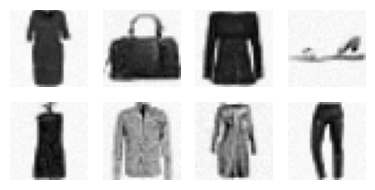

In [9]:
animate([*x_0s[::25], x_0s[-1]])

In [10]:
ImageEval.fashion_mnist?

Signature: ImageEval.fashion_mnist(fp='../models/fashion_mnist_classifier.pt', bs=512)
Docstring: <no docstring>
File:      ~/Desktop/SlowAI/nbs/slowai/fid.py
Type:      method

In [11]:
img_eval = ImageEval.fashion_mnist(bs=256)
img_eval.fid(x_0s[-1])

936.2686767578125

## Diffusers API

Now, for comparison, we'll use the diffusers API.

In [12]:
# |export
@torch.no_grad()
def diffusers_sample(sched, sz=(256, 1, 32, 32), skip_steps=None, **kwargs):
    if skip_steps is None:
        skip_steps = []
    x_t = torch.randn(sz).to(def_device)
    for t in tqdm(sched.timesteps):
        if t not in skip_steps:
            noise = unet(x_t, t).sample
        x_t = sched.step(noise, t, x_t).prev_sample
    return x_t

In [13]:
%%time
sched = DDPMScheduler(beta_end=0.01)
sched.set_timesteps((1000 - 50) // 3 + 50)
x_t = diffusers_sample(sched)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 366/366 [00:21<00:00, 17.04it/s]

CPU times: user 22.4 s, sys: 60.8 ms, total: 22.5 s
Wall time: 21.5 s


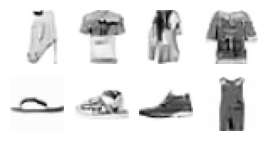

In [14]:
show_images(x_t[:8, ...], imsize=0.8)

In [15]:
img_eval.fid(x_t)

1133.3358154296875

For DDIM:

In [16]:
%%time
sched = DDIMScheduler(beta_end=0.01)
sched.set_timesteps((1000 - 50) // 3 + 50)
x_t = diffusers_sample(sched)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 366/366 [00:21<00:00, 16.98it/s]

CPU times: user 22.5 s, sys: 69.2 ms, total: 22.6 s
Wall time: 21.6 s


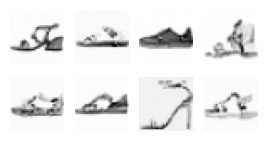

In [17]:
show_images(x_t[:8, ...], imsize=0.8)

In [18]:
img_eval.fid(x_t)

1313.16455078125

It turns out, these are similar quality.

## DDIM, algorithm

The basic idea is that different time steps may benefit from having different amounts of noise.

[This article](https://betterprogramming.pub/diffusion-models-ddpms-ddims-and-classifier-free-guidance-e07b297b2869#092e) does a good job of explaining the motivation.

In either algorithm, we determine the predicted noise, scale the predict apropriately for the time step, remove it from the latent representation and scale the sum.

$$
\hat{x}_0 = \frac{x_t - \sqrt{1-\bar{\alpha}_t} \epsilon_{\theta}(x_t)}{ \sqrt{ \bar{\alpha}_t } }
$$

Then, for **DDPM**, we re-add a fixed amount of noise to predict $x_{t-1}$. For DDIM, we add noise as a function of $\sigma$. (Because this can be made stochastic or deterministic, but the training objective is compatible, the name was changed to Denoising Diffusion Implicit Model.)

$$
q_\sigma ( x_{t-1} | x_t, x_0 ) = \mathcal{N} \left(
    \sqrt{\bar{\alpha}_{t-1}} x_0 + \sqrt{ 1 - \bar{\alpha}_{t-1} - \sigma_t^2 } \cdot \frac{x_t - \sqrt{\bar{\alpha}_t} x_0}{\sqrt{1-\bar{\alpha_t}}},
    \sigma_t^2 I
\right)
$$

We can rewrite this in terms of $x_{t-1}$, which is what we need to calculate for each step. This is composed of:

- Predicted $x_0 = \left( \frac{x_t - \sqrt{1-\bar{\alpha}_t} \epsilon_{\theta}^{(t)} }{\sqrt{ \bar{\alpha}_t }} \right)$ (this is the same as DDPM)
- Direction towards $x_t = \sqrt{ 1 - \bar{\alpha}_{t-1} - \sigma^{2}_{t} } \cdot \epsilon_{\theta}^{(t)} (x_t)$
- Random noise $= \sigma_t \epsilon_t$

$$
x_{t-1} = \sqrt{ \bar{\alpha}_{t-1} } \left( \frac{x_t - \sqrt{1-\bar{\alpha}_t} \epsilon_{\theta}^{(t)} }{\sqrt{ \bar{\alpha}_t }} \right) + \sqrt{ 1 - \bar{\alpha}_{t-1} - \sigma^{2}_{t} } \cdot \epsilon_{\theta}^{(t)} (x_t) + \sigma_t \epsilon_t
$$

and

$$
\begin{align*}
\sigma_t &= \eta \sqrt{(1-\bar{\alpha}_{t-1}) / (1-\bar{\alpha}_t)} \sqrt{1-\bar{\alpha_t} / \bar{\alpha}_{t-1}} \\
\eta &\in [0,1]
\end{align*}
$$

Typically, we use an $\eta$ parameter to interpolate between DDPM and DDPM, where $\eta=1$ corresponds to DDIM; if $\sigma_t=0$, this corresponds to DDPM.



In [19]:
# |export
@dataclass
class DDIMOutput:
    prev_sample: torch.Tensor


class DiffusersStyleDDPM(DDPM):
    @property
    def timesteps(self):
        return range(self.n_steps - 1, 0, -1)

    def step(self, noise, t, x_t):
        raise NotImplementedError


class DiffusersStyleDDIM(DiffusersStyleDDPM):
    def __init__(self, n_steps=1000, βmin=0.0001, βmax=0.02, η=1.0):  # η is eta
        super().__init__(n_steps, βmin, βmax)
        self.η = η

    def step(self, noise, t, x_t):
        ᾱ, η = self.ᾱ, self.η

        # Determine \hat{x}_0
        x_0_pred = (x_t - (1 - ᾱ[t]).sqrt() * noise) / ᾱ[t].sqrt()

        # Determine the direction towards x_t
        σ_t = η * ((1 - ᾱ[t - 1]) / (1 - ᾱ[t])).sqrt() * (1 - ᾱ[t] / ᾱ[t - 1]).sqrt()
        x_t_direction = (1 - ᾱ[t - 1] - σ_t**2).sqrt() * noise

        # Determine the x_{t-1} without nosie
        prev_sample = ᾱ[t - 1].sqrt() * x_0_pred + x_t_direction

        # Add random noise, if needed
        if t > 0:
            prev_sample += σ_t * torch.randn(x_t.shape).to(x_t.device)

        return DDIMOutput(prev_sample=prev_sample)

This is nice because the only parameters are $\bar{\alpha}$ and $\eta$.

In [20]:
sched = DiffusersStyleDDIM(βmax=0.01)
skip_steps = list(sched.timesteps)[:-50]
skip_steps = skip_steps[1::3] + skip_steps[2::3]
len(skip_steps)

632

In [21]:
%%time
x_t = diffusers_sample(sched, skip_steps=skip_steps)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999/999 [00:22<00:00, 44.14it/s]

CPU times: user 23.5 s, sys: 123 ms, total: 23.6 s
Wall time: 22.6 s


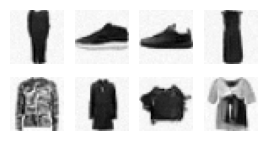

In [22]:
show_images(x_t[:8, ...], imsize=0.8)

In [23]:
img_eval.fid(x_t)

913.7852783203125

In [24]:
%%time
sched = DiffusersStyleDDIM(βmax=0.01)
steps = list(sched.timesteps)
skip_steps = {step for step in steps if step not in steps[::10] and step > 50}
x_t = diffusers_sample(sched, skip_steps=skip_steps)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999/999 [00:09<00:00, 102.68it/s]

CPU times: user 10.7 s, sys: 72.3 ms, total: 10.7 s
Wall time: 9.73 s


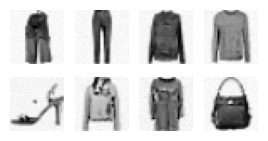

In [25]:
show_images(x_t[:8, ...], imsize=0.8)

In [26]:
img_eval.fid(x_t)

900.450927734375

This gives us a slight improvement in FID and a 2x increase in speed.

In [27]:
#| hide
import nbdev

nbdev.nbdev_export()